# Descriptive Analytics

**Goal:** To understand what is happening across multiple dimensions

**Focus Areas:**
- Growth Trajectory & Olist Maturity
- Budget vs Premium Order dynamics
- Product Category Performance
- Urban vs Rural Patterns
- Delivery delay impact quantification. 

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats

# Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# db connection
conn = sqlite3.connect('../data/ecommerce.db')
print('Connected to database')

Connected to database


### 1. Growth & Platform Maturity

#### 1.1 Platform Evaluation

In [5]:
# Monthly Metrics

growth_query = """
SELECT
    strftime('%Y-%m', order_purchase_timestamp) AS month,
    COUNT(*) AS num_orders,
    COUNT(DISTINCT customer_id) AS unique_customers,
    ROUND(AVG(total_order_value), 2) AS avg_order_value,
    ROUND(SUM(total_order_value), 2) AS total_revenue,
    ROUND(AVG(review_score), 2) AS avg_review,
    ROUND(AVG(delivery_delay_days), 2) AS avg_delay_days,
    ROUND(SUM(is_delayed) * 100.0 / COUNT(*), 2) AS delay_rate
FROM order_analysis
WHERE order_status = 'delivered'
GROUP BY month
ORDER BY month;
"""

growth_df = pd.read_sql_query(growth_query, conn)
growth_df['month'] = pd.to_datetime(growth_df['month'])

print("Monthly Biz Metrics:")
print(growth_df.head(10))

Monthly Biz Metrics:
       month  num_orders  unique_customers  avg_order_value  total_revenue  \
0 2016-09-01           1                 1           143.46         143.46   
1 2016-10-01         265               265           176.12       46671.48   
2 2016-12-01           1                 1            19.62          19.62   
3 2017-01-01         750               750           171.27      128454.10   
4 2017-02-01        1653              1653           164.95      272657.26   
5 2017-03-01        2546              2546           163.52      416327.30   
6 2017-04-01        2303              2303           169.99      391484.45   
7 2017-05-01        3546              3546           160.98      570837.90   
8 2017-06-01        3135              3135           157.62      494147.47   
9 2017-07-01        3872              3872           147.22      570027.48   

   avg_review  avg_delay_days  delay_rate  
0        1.00           36.32      100.00  
1        4.01          -36.08   


Platform Phases:
               month num_orders                avg_review delay_rate
               count        min   max     mean       mean       mean
phase                                                               
Early Growth       4          1   750   254.25       3.55      26.05
Growth Phase       3       1653  2546  2167.33       4.17       5.55
Maturity Phase    16       3135  7289  5559.94       4.17       7.57


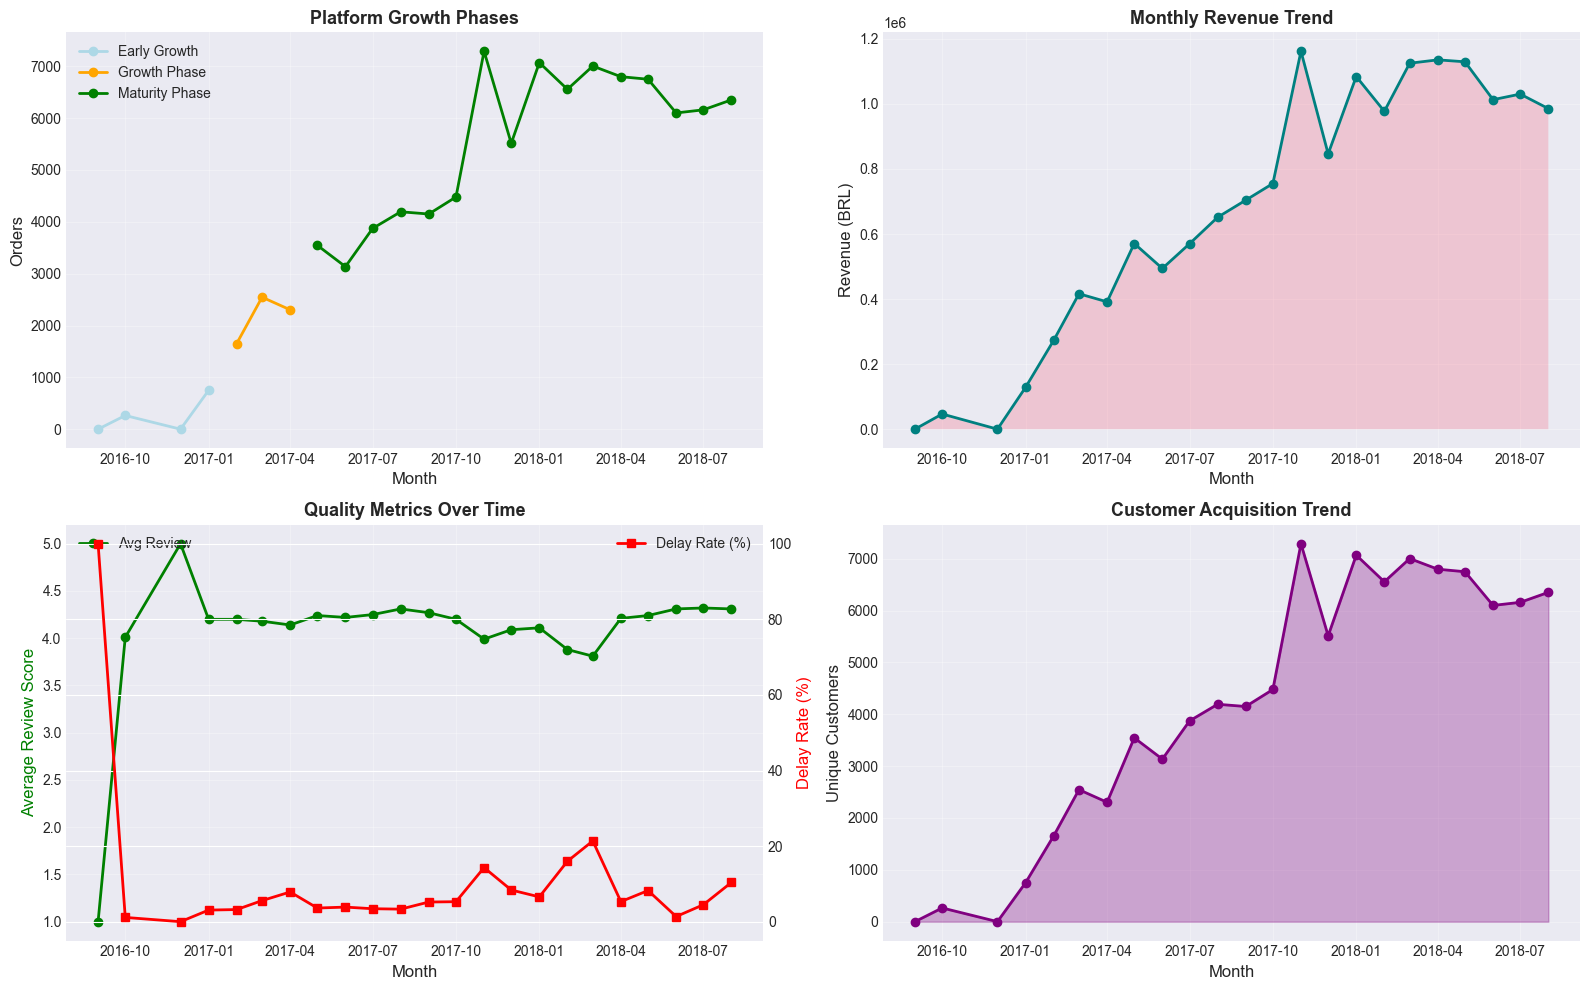

In [10]:
# Platform Phases based on Order Volume
def classify_phase(month, df):
    orders = df[df['month'] == month]['num_orders'].values[0]
    if orders < 1500:
        return 'Early Growth'
    elif orders < 3000:
        return 'Growth Phase'
    else:
        return 'Maturity Phase'
    
growth_df['phase'] = growth_df['month'].apply(lambda x: classify_phase(x, growth_df))

print("\nPlatform Phases:")
print(growth_df.groupby('phase').agg({
    'month': 'count', 
    'num_orders': ['min', 'max', 'mean'],
    'avg_review': 'mean',
    'delay_rate': 'mean'
}).round(2))


# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Orders over time with phases
colors = {'Early Growth': 'lightblue', 'Growth Phase': 'orange', 'Maturity Phase': 'green'}
for phase in ['Early Growth', 'Growth Phase', 'Maturity Phase']:
    phase_data = growth_df[growth_df['phase'] == phase]
    axes[0, 0].plot(phase_data['month'], phase_data['num_orders'], 
                   marker='o', linewidth=2, label=phase, color=colors[phase])

axes[0, 0].set_xlabel('Month', fontsize=12)
axes[0, 0].set_ylabel('Orders', fontsize=12)
axes[0, 0].set_title('Platform Growth Phases', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Revenue growth
axes[0, 1].plot(growth_df['month'], growth_df['total_revenue'], 
               marker='o', linewidth=2, color='teal')
axes[0, 1].fill_between(growth_df['month'], growth_df['total_revenue'], alpha=0.3)
axes[0, 1].set_xlabel('Month', fontsize=12)
axes[0, 1].set_ylabel('Revenue (BRL)', fontsize=12)
axes[0, 1].set_title('Monthly Revenue Trend', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Quality metrics over time
ax2 = axes[1, 0]
ax2_twin = ax2.twinx()
ax2.plot(growth_df['month'], growth_df['avg_review'], 
        marker='o', linewidth=2, color='green', label='Avg Review')
ax2_twin.plot(growth_df['month'], growth_df['delay_rate'], 
             marker='s', linewidth=2, color='red', label='Delay Rate (%)')
ax2.set_xlabel('Month', fontsize=12)
ax2.set_ylabel('Average Review Score', fontsize=12, color='green')
ax2_twin.set_ylabel('Delay Rate (%)', fontsize=12, color='red')
ax2.set_title('Quality Metrics Over Time', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper left')
ax2_twin.legend(loc='upper right')

# Customer acquisition
axes[1, 1].plot(growth_df['month'], growth_df['unique_customers'], 
               marker='o', linewidth=2, color='purple')
axes[1, 1].fill_between(growth_df['month'], growth_df['unique_customers'], alpha=0.3, color='purple')
axes[1, 1].set_xlabel('Month', fontsize=12)
axes[1, 1].set_ylabel('Unique Customers', fontsize=12)
axes[1, 1].set_title('Customer Acquisition Trend', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/platform_maturity.png', dpi=300, bbox_inches='tight')
plt.show()



#### 1.2 Seasonality & Special Events

In [13]:
# Identify peak months
peak_months = growth_df.nlargest(3, 'num_orders')[['month', 'num_orders', 'total_revenue']]

print("Top 3 Peak Months:")
print(peak_months)


Top 3 Peak Months:
        month  num_orders  total_revenue
13 2017-11-01        7289     1161920.53
15 2018-01-01        7069     1084202.96
17 2018-03-01        7003     1125026.32


**Peak Month Hypothesis**

- 11/1/2017 - Guessing they might have had Thanksgiving offers
- 01/01/2018 - New Year Orders
- 03/01/2018 - Based on Google Search - Looks like its when Rio de Janeiro was established.  

Peak Months Detailed Analysis:
Total records: 2,056

----------------------------------------------------------------------
MONTH: 2017-11
----------------------------------------------------------------------

Top 5 Categories:
                 num_orders  total_revenue
category                                  
bed_bath_table          804       87957.63
sports_leisure          542       62686.24
furniture_decor         536       62091.27
health_beauty           519       78274.40
toys                    443       62611.26

Top 5 States:
                num_orders  total_revenue
customer_state                           
SP                    2919      350790.18
RJ                    1018      147782.40
MG                     932      132686.09
RS                     417       57463.27
PR                     367       45751.34

SP concentration: 39.7%


----------------------------------------------------------------------
MONTH: 2018-01
------------------------------------------------

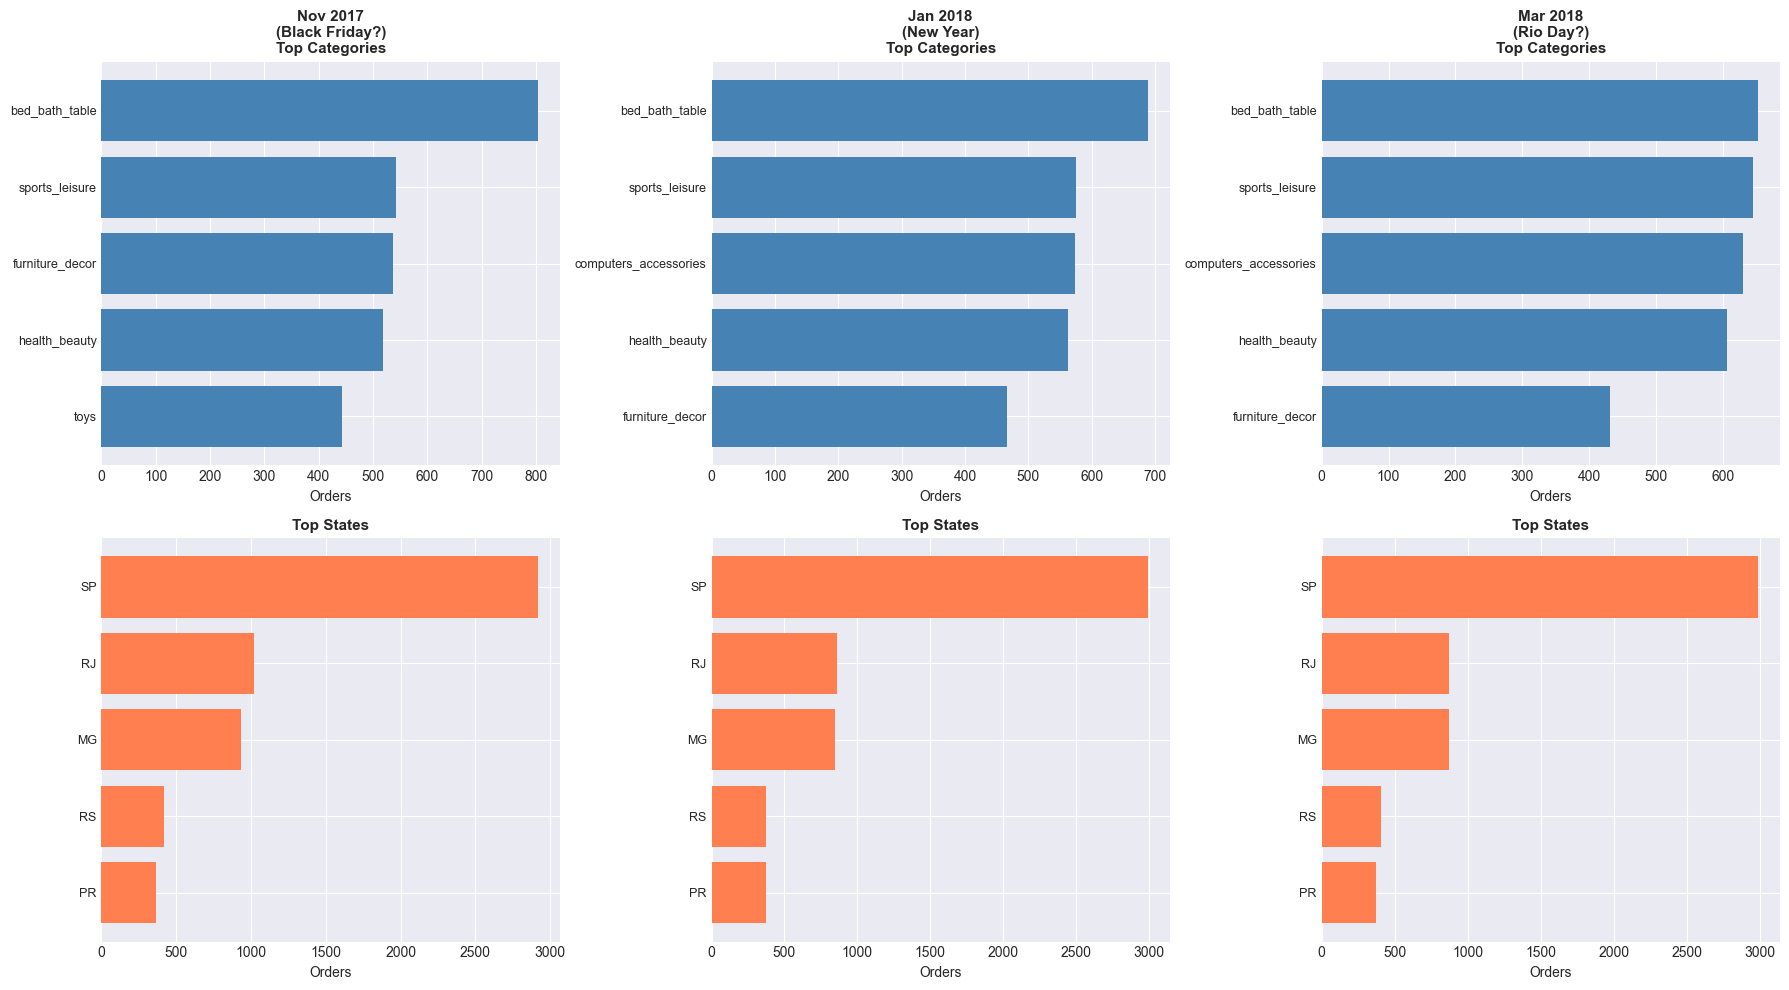

In [16]:
# Analyzing Peak Months in Detail - Products & Region

peak_months_query = """
SELECT 
    strftime('%Y-%m', o.order_purchase_timestamp) as month,
    COALESCE(pct.product_category_name_english, p.product_category_name, 'Unknown') as category,
    c.customer_state,
    COUNT(DISTINCT o.order_id) as num_orders,
    COUNT(oi.order_item_id) as num_items,
    ROUND(SUM(oi.price), 2) as total_revenue,
    ROUND(AVG(oi.price), 2) as avg_price
FROM orders o
JOIN customers c ON o.customer_id = c.customer_id
JOIN order_items oi ON o.order_id = oi.order_id
JOIN products p ON oi.product_id = p.product_id
LEFT JOIN product_category_name_translation pct 
    ON p.product_category_name = pct.product_category_name
WHERE o.order_status = 'delivered'
  AND strftime('%Y-%m', o.order_purchase_timestamp) IN ('2017-11', '2018-01', '2018-03')
GROUP BY month, category, c.customer_state
ORDER BY month, num_orders DESC
"""

peak_details = pd.read_sql(peak_months_query, conn)

print("Peak Months Detailed Analysis:")
print(f"Total records: {len(peak_details):,}\n")

# Analyzing each peak month
for month in ['2017-11', '2018-01', '2018-03']:
    month_data = peak_details[peak_details['month'] == month]
    
    print("-" * 70)
    print(f"MONTH: {month}")
    print("-" * 70)
    
    # Top 5 categories
    top_categories = month_data.groupby('category').agg({
        'num_orders': 'sum',
        'total_revenue': 'sum'
    }).nlargest(5, 'num_orders')
    
    print(f"\nTop 5 Categories:")
    print(top_categories)
    
    # Top 5 states
    top_states = month_data.groupby('customer_state').agg({
        'num_orders': 'sum',
        'total_revenue': 'sum'
    }).nlargest(5, 'num_orders')
    
    print(f"\nTop 5 States:")
    print(top_states)
    
    # Calculate what % of orders came from SP
    sp_pct = (month_data[month_data['customer_state'] == 'SP']['num_orders'].sum() / 
              month_data['num_orders'].sum() * 100)
    print(f"\nSP concentration: {sp_pct:.1f}%")
    print("\n")

# Visualizing peak month patterns
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

months = ['2017-11', '2018-01', '2018-03']
month_labels = ['Nov 2017\n(Black Friday?)', 'Jan 2018\n(New Year)', 'Mar 2018\n(Rio Day?)']

for idx, (month, label) in enumerate(zip(months, month_labels)):
    month_data = peak_details[peak_details['month'] == month]
    
    # Top categories
    top_cats = month_data.groupby('category')['num_orders'].sum().nlargest(5).sort_values()
    axes[0, idx].barh(top_cats.index, top_cats.values, color='steelblue')
    axes[0, idx].set_xlabel('Orders', fontsize=10)
    axes[0, idx].set_title(f'{label}\nTop Categories', fontsize=11, fontweight='bold')
    axes[0, idx].tick_params(axis='y', labelsize=9)
    
    # Top states
    top_states = month_data.groupby('customer_state')['num_orders'].sum().nlargest(5).sort_values()
    axes[1, idx].barh(top_states.index, top_states.values, color='coral')
    axes[1, idx].set_xlabel('Orders', fontsize=10)
    axes[1, idx].set_title(f'Top States', fontsize=11, fontweight='bold')
    axes[1, idx].tick_params(axis='y', labelsize=9)

plt.tight_layout()
plt.savefig('../reports/figures/peak_months_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


In [18]:
# Comparing Peak Month vs Average Month

print("PEAK MONTHS vs AVERAGE COMPARISON")


avg_month_query = """
SELECT 
    ROUND(AVG(monthly_orders), 2) as avg_monthly_orders,
    ROUND(AVG(monthly_revenue), 2) as avg_monthly_revenue
FROM (
    SELECT 
        strftime('%Y-%m', order_purchase_timestamp) as month,
        COUNT(*) as monthly_orders,
        SUM(total_order_value) as monthly_revenue
    FROM order_analysis
    WHERE order_status = 'delivered'
    GROUP BY month
)
"""

avg_stats = pd.read_sql(avg_month_query, conn)

print(f"\nAverage Month: {avg_stats['avg_monthly_orders'][0]:,.0f} orders")
print(f"\nPeak Months:")
print(f"  Nov 2017: 7,289 orders ({7289/avg_stats['avg_monthly_orders'][0]:.1f}x average)")
print(f"  Jan 2018: 7,069 orders ({7069/avg_stats['avg_monthly_orders'][0]:.1f}x average)")
print(f"  Mar 2018: 7,003 orders ({7003/avg_stats['avg_monthly_orders'][0]:.1f}x average)")

print("\nInsights:")
print("  • Nov 2017 is likely BLACK FRIDAY (big e-commerce event in Brazil)")
print("  • Jan 2018 could be post-holiday shopping + New Year sales")
print("  • Mar 2018 - check if there were any promotions or events")

PEAK MONTHS vs AVERAGE COMPARISON

Average Month: 4,195 orders

Peak Months:
  Nov 2017: 7,289 orders (1.7x average)
  Jan 2018: 7,069 orders (1.7x average)
  Mar 2018: 7,003 orders (1.7x average)

Insights:
  • Nov 2017 is likely BLACK FRIDAY (big e-commerce event in Brazil)
  • Jan 2018 could be post-holiday shopping + New Year sales
  • Mar 2018 - check if there were any promotions or events


In [19]:
print("*" * 70)
print("PEAK MONTH ANALYSIS - KEY FINDINGS")
print("*" * 70)

print("\nSURPRISING DISCOVERY:")
print("  • All 3 peak months show IDENTICAL category patterns")
print("  • bed_bath_table dominates in all cases")
print("  • No 'event-specific' shopping behavior detected")

print("\nWHAT THIS MEANS:")
print("  • Nov 2017 spike: Likely platform maturity + seasonal home shopping")
print("  • Jan 2018: Post-holiday home organization purchases")
print("  • Mar 2018: Continued growth trajectory")

print("\nBRAZILIAN E-COMMERCE INSIGHT:")
print("  • Home goods (bed/bath/furniture) are PRIMARY purchase drivers")
print("  • Unlike US Black Friday (electronics-heavy)")
print("  • Brazilian market shows strong home improvement focus")

print("\nGEOGRAPHIC CONSISTENCY:")
print("  • SP dominates regardless of event/month")
print("  • Same top 5 states in identical order")
print("  • Suggests structural market concentration, not event-driven")

print("\n" + "*" * 70)

**********************************************************************
PEAK MONTH ANALYSIS - KEY FINDINGS
**********************************************************************

SURPRISING DISCOVERY:
  • All 3 peak months show IDENTICAL category patterns
  • bed_bath_table dominates in all cases
  • No 'event-specific' shopping behavior detected

WHAT THIS MEANS:
  • Nov 2017 spike: Likely platform maturity + seasonal home shopping
  • Jan 2018: Post-holiday home organization purchases
  • Mar 2018: Continued growth trajectory

BRAZILIAN E-COMMERCE INSIGHT:
  • Home goods (bed/bath/furniture) are PRIMARY purchase drivers
  • Unlike US Black Friday (electronics-heavy)
  • Brazilian market shows strong home improvement focus

GEOGRAPHIC CONSISTENCY:
  • SP dominates regardless of event/month
  • Same top 5 states in identical order
  • Suggests structural market concentration, not event-driven

**********************************************************************


### 2. Premium vs Budget Order Dynamics